# TIM - The Ineference Machine

## This is the first tutorial for TIM, the code-formally-known as PEYOte.
May PEYOte rest in peace

TIM is a fast, easy to use parameter estimation code for gravitational-wave astronomy.  This tutorial will take you through the basics steps of creating a model waveform, injecting that waveform into simulated noise, and then recovering that signal.

In [1]:
%matplotlib notebook
import numpy as np
import pylab as plt

%load_ext autoreload
%autoreload 2
import peyote
from dynesty import plotting as dyplot

## Define a source and simulate data

<IPython.core.display.Javascript object>


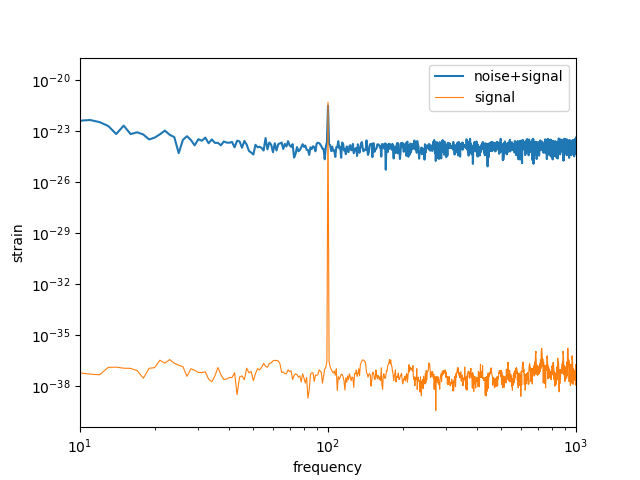

In [2]:
# Properties of the data
time_duration = 1.
sampling_frequency = 4096.

# Simulated source properties
simulation_parameters = dict(
    A=1e-21, 
    f=100,
    geocent_time=0,
    ra=1, 
    dec=2, 
    psi=0)

# Make a source instance and get the frequency domain realisation
source = peyote.source.SimpleSinusoidSource(
    'sin', sampling_frequency, time_duration)
hf_signal = source.frequency_domain_strain(simulation_parameters)

# Simulate the data in H1
IFO = peyote.detector.H1
hf_noise, frequencies = IFO.power_spectral_density.get_noise_realisation(
    sampling_frequency, time_duration)
IFO.set_data(frequency_domain_strain=hf_noise)
IFO.inject_signal(source, simulation_parameters)
IFO.set_spectral_densities(frequencies)
IFO.whiten_data()

# Plot the noise and signal
plt.loglog(frequencies, np.abs(hf_noise), lw=1.5, label='noise+signal')
plt.loglog(frequencies, np.abs(hf_signal['plus']), lw=0.8, label='signal')
plt.xlim(10, 1000)
plt.legend()
plt.xlabel(r'frequency')
plt.ylabel(r'strain')
plt.show()

## Search the data

Search parameters = ['A', 'f']


<IPython.core.display.Javascript object>


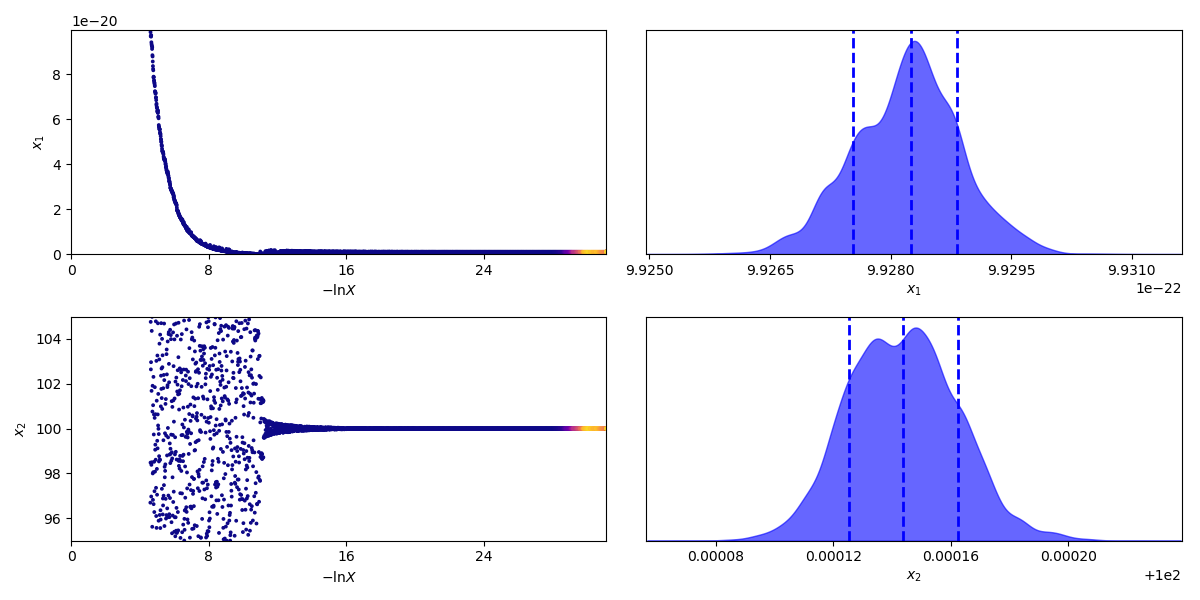

In [12]:
likelihood = peyote.likelihood.likelihood([IFO], source)

prior = simulation_parameters
prior['f'] = peyote.parameter.Parameter(
    'f', prior=peyote.prior.Uniform(lower=95, upper=105))
prior['A'] = peyote.parameter.Parameter(
    'A', prior=peyote.prior.Uniform(lower=0, upper=1e-19))


res = peyote.run_sampler(likelihood, prior, 'nestle', npoints=100)
fig, axes = dyplot.traceplot(res)
fig.tight_layout()
fig.show()